# Jack's Car Rental Problem

Here are key specific points about the problem:
•2 locations A, B
•Each location can only hold 20 cars.
•Every time a car is rented, we earn $10 (Reward)
•Every time we move a car overnight to another location, it costs us $2 (Negative Reward).
•The maximum number of cars we can move overnight is 5 (Action).
•The number of cars requested and returned at each location (n) on any given day are Poisson 
random variables.
•The expected number (lambda) ofrental requests at the first and second location is 3 and 4 
respectively.
•The expected number ofrental returns at the first and second location is 3 and 2 respectively.
•Our discount rate for future returns, (γ), is 0.9.
•The time step are days (thus, one step in an iteration can be considered a full day), the state is 
the number of cars at each location at the end of the day, and the actions are the net number of 
cars moved between the two locations overnight.

**version 1**
Let’s see what happens if we add some non-linearities [as they are costs or conditions not directly 
proportional to the number of cars moved, as they were the original ones stated for the problem in 
version 0] like the following to the problem above:
•One of Jack’s employees at the first location rides a bus home each night and lives near the 
second location. He is happy to shuttle one car to the second location for free.
•Each additional car still costs $2, as do all cars moved in the other direction.
•In addition, Jack has limited parking space at each location. If more than 10 cars are kept 
overnight at a location (after any moving of cars), then an additional cost of $4 must be incurred 
to use a second parking lot (independent of how many cars are kept there) We will have one 
more reward of -$4 for the second parking lot if needed


## Problem definition

In [1]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import sys

In [2]:
#Problem Parameters
class jcp:
    @staticmethod
    def max_cars():
        return 20

    @staticmethod
    def γ():
        return 0.9

    @staticmethod
    def credit_reward():
        return 10

    @staticmethod
    def moving_cost_per_car():
        # Base transfer cost in dollars per paid moved car.
        return 2

    @staticmethod
    def free_shuttle_from_A_to_B():
        # Number of free A -> B shuttles per day
        return 1

    @staticmethod
    def overflow_threshold():
        # Parking overflow starts when cars kept overnight are > 10.
        return 10

    @staticmethod
    def overflow_parking_cost():
        # Fixed extra cost per location that exceeds the threshold.
        return 4


In [3]:
class poisson_:
    
    def __init__(self, λ):
        self.λ = λ
        
        ε = 0.01
        
        # [α , β] is the range of n's for which the pmf value is above ε
        self.α = 0
        state = 1
        self.vals = {}
        summer = 0
        
        while(True):
            if state == 1:
                temp = poisson.pmf(self.α, self.λ) 
                if(temp <= ε):
                    self.α+=1
                else:
                    self.vals[self.α] = temp
                    summer += temp
                    self.β = self.α+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.β, self.λ)
                if(temp > ε):
                    self.vals[self.β] = temp
                    summer += temp
                    self.β+=1
                else:
                    break    
        
        # normalizing the pmf (probability mass function), values of n outside of [α, β] have pmf = 0
        
        added_val = (1-summer)/(self.β-self.α)
        for key in self.vals:
            self.vals[key] += added_val
        
            
    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        return Ret_value

In [4]:
# Poisson Distribution - examples
ex = poisson_(3)
print(ex.λ)
print(ex.α,ex.β)
print(ex.vals)

3
0 8
{0: np.float64(0.05127513134990861), 1: np.float64(0.15084926808563653), 2: np.float64(0.2255298706374324), 3: np.float64(0.2255298706374324), 4: np.float64(0.1695194187235855), 5: np.float64(0.10230687642696924), 6: np.float64(0.051897469704506906), 7: np.float64(0.023092094434528487)}


In [5]:
#A class holding the properties of a location together
class location:
    
    def __init__(self, req, ret):
        self.α = req                             #value of lambda for requests
        self.β = ret                             #value of lambda for returns
        self.poissonα = poisson_(self.α)
        self.poissonβ = poisson_(self.β)

In [6]:
#Location initialisation

A = location(3,3)
B = location(4,2)

In [7]:
#Initializing the value and policy matrices. Initial policy has zero value for all states.

value = np.zeros((jcp.max_cars()+1, jcp.max_cars()+1))
policy = value.copy().astype(int)

In [8]:
def apply_action(state, action):
    return [max(min(state[0] - action, jcp.max_cars()),0) , max(min(state[1] + action, jcp.max_cars()),0)]

## Expected Reward

In [9]:
def expected_reward(state, action):
    global value
    """
    state  : It's a pair of integers, # of cars at A and at B
    action : # of cars transferred from A to B,  -5 <= action <= 5
    """

    ψ = 0  # total expected return for this (state, action)

    # State after overnight transfers and before rental requests happen.
    new_state = apply_action(state, action)

    # New transfer cost rule:
    #   A->B (action > 0): first moved car is free, remaining cars cost $2 each.
    #   B->A (action < 0): every moved car costs $2 each.
    if action > 0:
        # Subtract one from action
        paid_moves = max(action - jcp.free_shuttle_from_A_to_B(), 0)
    else:
        paid_moves = abs(action)
    ψ -= jcp.moving_cost_per_car() * paid_moves

    # After moving cars overnight, each location with
    # more than 10 cars incurs an additional fixed $4 parking-lot cost.
    if new_state[0] > jcp.overflow_threshold():
        ψ -= jcp.overflow_parking_cost()
    if new_state[1] > jcp.overflow_threshold():
        ψ -= jcp.overflow_parking_cost()

    #there are four discrete random variables which determine the probability distribution of the reward and next state

    for Aα in range(A.poissonα.α, A.poissonα.β):
        for Bα in range(B.poissonα.α, B.poissonα.β):
            for Aβ in range(A.poissonβ.α, A.poissonβ.β):
                for Bβ in range(B.poissonβ.α, B.poissonβ.β):
                    # all four variables are independent of each other
                    ζ = A.poissonα.vals[Aα] * B.poissonα.vals[Bα] * A.poissonβ.vals[Aβ] * B.poissonβ.vals[Bβ]

                    valid_requests_A = min(new_state[0], Aα)
                    valid_requests_B = min(new_state[1], Bα)

                    rew = (valid_requests_A + valid_requests_B) * jcp.credit_reward()

                    #calculating the new state based on the values of the four random variables
                    new_s = [0, 0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + Aβ, jcp.max_cars()), 0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + Bβ, jcp.max_cars()), 0)

                    # Bellman's equation
                    ψ += ζ * (rew + jcp.γ() * value[new_s[0]][new_s[1]])

    return ψ


## Policy Evaluation

In [10]:
def policy_evaluation():
    
    global value
    
    # here policy_evaluation has a static variable ε whose values decreases over time
    ε = policy_evaluation.ε
    
    policy_evaluation.ε /= 10 
    
    while(1):
        δ = 0
        
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                # value[i][j] denotes the value of the state [i,j]
                
                old_val = value[i][j]
                value[i][j] = expected_reward([i,j], policy[i][j])
                
                δ = max(δ, abs(value[i][j] - old_val))
                #print('.+\b', end = '')
                #sys.stdout.flush()
        print('\r'+'δ =',δ, end = '')
        #sys.stdout.flush()
    
        if δ < ε:
            break

In [11]:
#initial value of ε
policy_evaluation.ε = 50

## Policy Improvement

In [12]:
def policy_improvement():
    
    global policy
    
    policy_stable = True
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            old_action = policy[i][j]
            
            max_act_val = None
            max_act = None
            
            τ12 = min(i,5)       # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
            τ21 = -min(j,5)      # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1
            
            for act in range(τ21,τ12+1):
                σ = expected_reward([i,j], act)
                if max_act_val == None:
                    max_act_val = σ
                    max_act = act
                elif max_act_val < σ:
                    max_act_val = σ
                    max_act = act
                
            policy[i][j] = max_act
            
            if old_action!= policy[i][j]:
                policy_stable = False
    
    return policy_stable

In [13]:
def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5)
    ax.invert_yaxis()
    # plt.savefig('policy'+str(save_policy.counter)+'.svg')
    plt.show()
    plt.close()
    
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5)
    ax.invert_yaxis()
    # plt.savefig('value'+ str(save_value.counter)+'.svg')
    plt.show()
    plt.close()

## Main Loop

In [14]:
save_policy.counter = 0
save_value.counter = 0

δ = 40.395067108561318

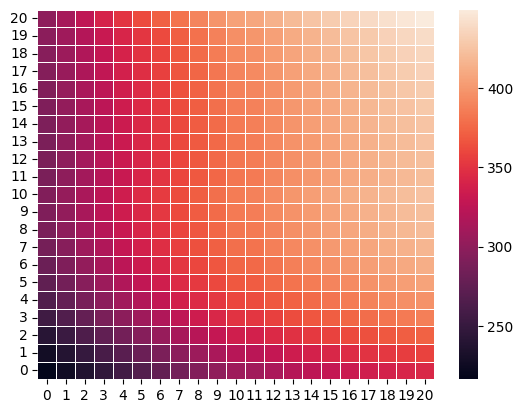

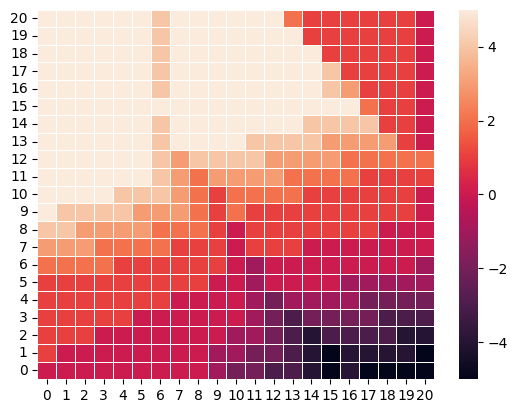

δ = 4.5594772210557726

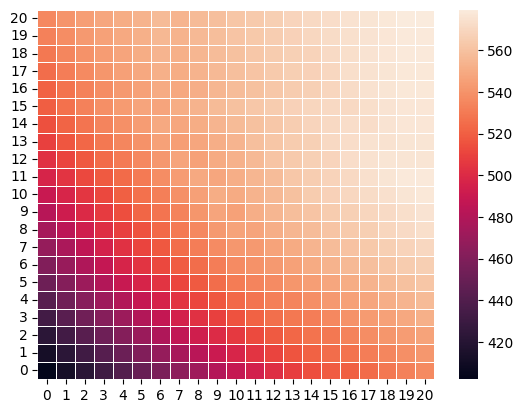

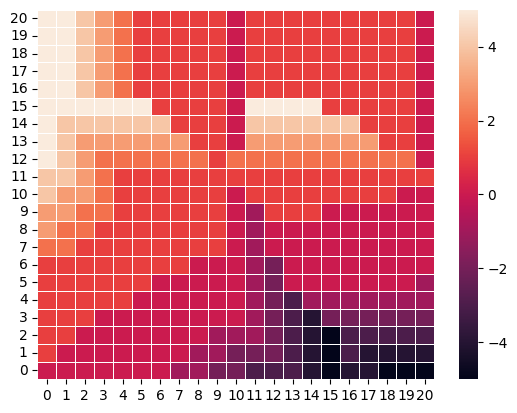

δ = 0.47550893404741146

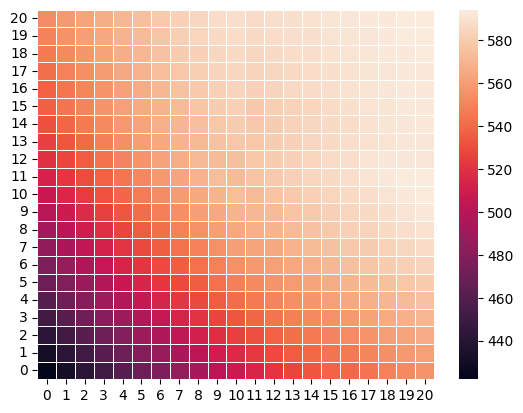

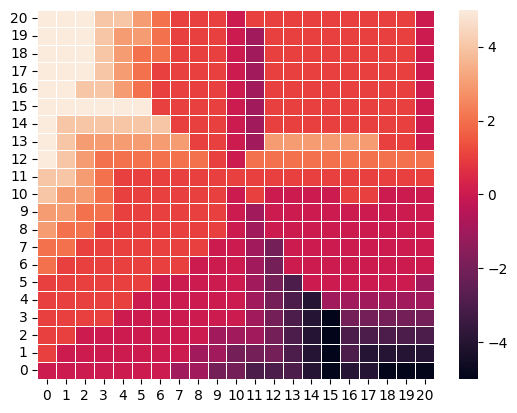

δ = 0.04439153050952882

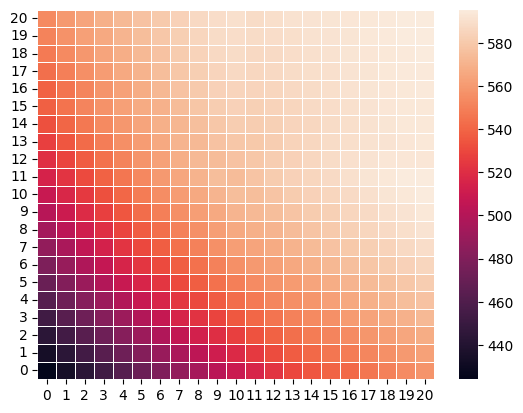

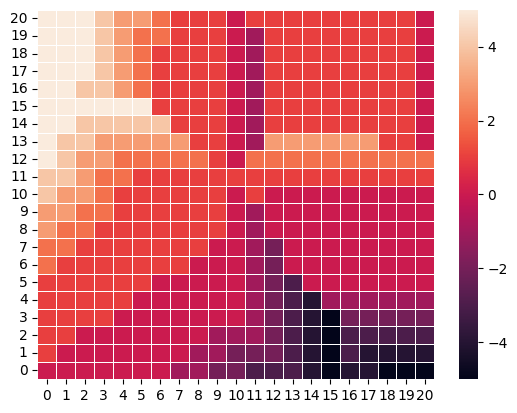

δ = 0.004930473369483934

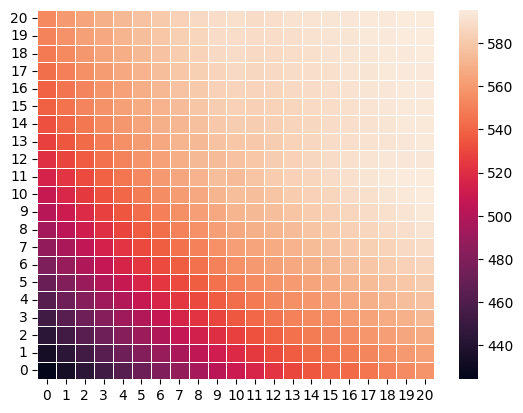

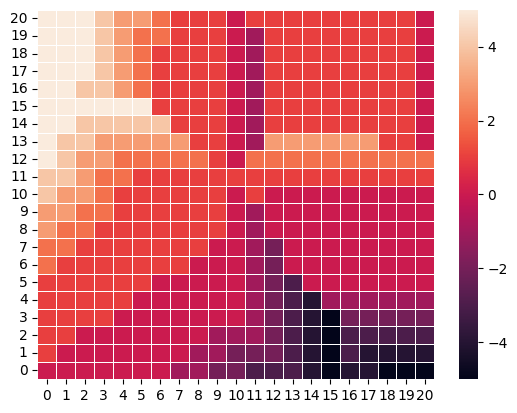

In [15]:
while(True):
    policy_evaluation()
    ρ = policy_improvement()
    save_value()
    save_policy()
    if ρ == True:
        break

## Summary

Jack's Car Rental is modelled as a finite MDP with state `(cars_at_A, cars_at_B)` and action `a` (cars moved overnight from A to B).
The `expected_reward` function computes one-step expected return by combining:
- transfer/parking costs from the Version 1 rules,
- rental income from fulfilled requests,
- discounted value of next states (Bellman expectation).

Then classic policy iteration is used:
1. `policy_evaluation()` updates `value` for the current policy until convergence threshold `ε`.
2. `policy_improvement()` greedily selects the best action per state using `expected_reward`.
3. The loop repeats until the policy is stable.

With the updated Version 1 costs, the learned policy typically becomes **less symmetric** than Version 0:
- one free A->B move encourages small positive transfers,
- overflow parking penalty discourages ending nights with too many cars at either location.
So the final policy/value maps usually show stronger balancing behavior around the `>10 cars` boundary.

